# Generates images from text prompts with VQGAN and CLIP (Mse regulized zquantize method).

By jbustter https://twitter.com/jbusted1 .
Based on a notebook by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings)


*Modified by: Justin John*


In [1]:
#@markdown #**Check GPU type**
#@markdown ### Factory reset runtime if you don't have the desired GPU.

#@markdown ---




#@markdown V100 = Excellent (*Available only for Colab Pro Users*)

#@markdown P100 = Very Good

#@markdown T4 = Good

#@markdown K80 = Meh

#@markdown P4 = Aight

#@markdown ---

!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2080 (UUID: GPU-55e28532-9bf5-f82d-2f5a-bf6f7c80b1fc)


In [2]:
#@markdown #**Selection of models to download**
#@markdown ---
#@markdown OpenImages and  ImageNet models

#@markdown ---

imagenet_16384 = False #@param {type:"boolean"}

openimages_8192 = False #@param {type:"boolean"}


if imagenet_16384:
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384
if openimages_8192:
  !curl -L -o vqgan_openimages_f16_8192.ckpt -C - 'https://dl.nmkd.de/ai/clip/vqgan/8k-2021-06/vqgan-f8-8192.ckpt' #ImageNet 16384
  !curl -L -o vqgan_openimages_f16_8192.yaml -C - 'https://dl.nmkd.de/ai/clip/vqgan/8k-2021-06/vqgan-f8-8192.yaml' #ImageNet 16384


In [3]:
#@markdown #**Loading libraries and definitions**

import argparse
import math
from pathlib import Path
import sys

sys.path.append('./taming-transformers')

from IPython import display
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
import numpy as np

from CLIP import clip

import kornia.augmentation as K

def noise_gen(shape):
    n, c, h, w = shape
    noise = torch.zeros([n, c, 1, 1])
    for i in reversed(range(5)):
        h_cur, w_cur = h // 2**i, w // 2**i
        noise = F.interpolate(noise, (h_cur, w_cur), mode='bicubic', align_corners=False)
        noise += torch.randn([n, c, h_cur, w_cur]) / 5
    return noise


def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
    

# def replace_grad(fake, real):
#     return fake.detach() - real.detach() + real


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

replace_grad = ReplaceGrad.apply

clamp_with_grad = ClampWithGrad.apply
# clamp_with_grad = torch.clamp

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        
        input_normed = F.normalize(input.unsqueeze(1), dim=2)#(input / input.norm(dim=-1, keepdim=True)).unsqueeze(1)# 
        embed_normed = F.normalize((self.embed).unsqueeze(0), dim=2)#(self.embed / self.embed.norm(dim=-1, keepdim=True)).unsqueeze(0)#

        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])

def one_sided_clip_loss(input, target, labels=None, logit_scale=100):
    input_normed = F.normalize(input, dim=-1)
    target_normed = F.normalize(target, dim=-1)
    logits = input_normed @ target_normed.T * logit_scale
    if labels is None:
        labels = torch.arange(len(input), device=logits.device)
    return F.cross_entropy(logits, labels)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def set_cut_pow(self, cut_pow):
      self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        cutouts_full = []
        
        min_size_width = min(sideX, sideY)
        lower_bound = float(self.cut_size/min_size_width)
        
        for ii in range(self.cutn):
            
            
          # size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
          size = int(min_size_width*torch.zeros(1,).normal_(mean=.8, std=.3).clip(lower_bound, 1.)) # replace .5 with a result for 224 the default large size is .95
          # size = int(min_size_width*torch.zeros(1,).normal_(mean=.9, std=.3).clip(lower_bound, .95)) # replace .5 with a result for 224 the default large size is .95

          offsetx = torch.randint(0, sideX - size + 1, ())
          offsety = torch.randint(0, sideY - size + 1, ())
          cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
          cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

        
        cutouts = torch.cat(cutouts, dim=0)

        # if args.use_augs:
        #   cutouts = augs(cutouts)

        # if args.noise_fac:
        #   facs = cutouts.new_empty([cutouts.shape[0], 1, 1, 1]).uniform_(0, args.noise_fac)
        #   cutouts = cutouts + facs * torch.randn_like(cutouts)
        

        return clamp_with_grad(cutouts, 0, 1)


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

class TVLoss(nn.Module):
    def forward(self, input):
        input = F.pad(input, (0, 1, 0, 1), 'replicate')
        x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
        y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
        diff = x_diff**2 + y_diff**2 + 1e-8
        return diff.mean(dim=1).sqrt().mean()

class GaussianBlur2d(nn.Module):
    def __init__(self, sigma, window=0, mode='reflect', value=0):
        super().__init__()
        self.mode = mode
        self.value = value
        if not window:
            window = max(math.ceil((sigma * 6 + 1) / 2) * 2 - 1, 3)
        if sigma:
            kernel = torch.exp(-(torch.arange(window) - window // 2)**2 / 2 / sigma**2)
            kernel /= kernel.sum()
        else:
            kernel = torch.ones([1])
        self.register_buffer('kernel', kernel)

    def forward(self, input):
        n, c, h, w = input.shape
        input = input.view([n * c, 1, h, w])
        start_pad = (self.kernel.shape[0] - 1) // 2
        end_pad = self.kernel.shape[0] // 2
        input = F.pad(input, (start_pad, end_pad, start_pad, end_pad), self.mode, self.value)
        input = F.conv2d(input, self.kernel[None, None, None, :])
        input = F.conv2d(input, self.kernel[None, None, :, None])
        return input.view([n, c, h, w])

class EMATensor(nn.Module):
    """implmeneted by Katherine Crowson"""
    def __init__(self, tensor, decay):
        super().__init__()
        self.tensor = nn.Parameter(tensor)
        self.register_buffer('biased', torch.zeros_like(tensor))
        self.register_buffer('average', torch.zeros_like(tensor))
        self.decay = decay
        self.register_buffer('accum', torch.tensor(1.))
        self.update()
    
    @torch.no_grad()
    def update(self):
        if not self.training:
            raise RuntimeError('update() should only be called during training')

        self.accum *= self.decay
        self.biased.mul_(self.decay)
        self.biased.add_((1 - self.decay) * self.tensor)
        self.average.copy_(self.biased)
        self.average.div_(1 - self.accum)

    def forward(self):
        if self.training:
            return self.tensor
        return self.average

%mkdir ./content/vids

mkdir: cannot create directory ‘./content/vids’: File exists


## **Arguments**         

In [4]:
rng = np.random.default_rng()


/home/lobrien/anaconda3/envs/vqgan-clp/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#@markdown #**Double-click here and input**
#@markdown like prompts, iterations and other stuff  
#@markdown *(This is a W.I.P  space and will be simplified further soon)*
#@markdown ---

ps = [
    "A formal portrait of a blond man in a white suit raising a martini glass while standing on a green lawn in front of a mansion on a harbor on a Summer day",
    "A black and white woodprint of a monster of vaguely anthropoid outline, but with an octopus-like head whose face was a mass of feelers, a scaly, rubbery-looking body, prodigious claws on hind and fore feet, and long, narrow wings behind",
    "A photo of a bearded fisherman wearing a Greek fishing cap, on a stormy sea at night",
    "A format portrait of a brunette flapper at a crowded bar with a jazz band playing on a bandstand",
    "A photorealistic of a dark haired man with a strong jaw holding a thompson submachine gun",
    "A formal portrait of an intelligent brunette woman her hair in a bun standing in front of a chalkboard covered in quantum mechanics equations",
    "A black and white ink drawing of a monstrous crab approaching a mansion on a cliff overlooking a stormy ocean"
]


args = argparse.Namespace(
    
    prompts=[ps[6]],
    size=[320, 256], 
    init_image= None, #'./seeds/fisherman.png',
    init_weight= 0.5,

    # clip model settings
    clip_model='ViT-B/32',
    vqgan_config='vqgan_openimages_f16_8192.yaml',         
    vqgan_checkpoint='vqgan_openimages_f16_8192.ckpt',
    step_size=0.1,
    
    # cutouts / crops
    cutn=64,
    cut_pow=1,

    # display
    display_freq=25,
    #seed=158759,
    seed = rng.integers(low=0,high=sys.maxsize),
    use_augs = True,
    noise_fac= 0.1,
    ema_val = 0.99,

    record_generation=True,

    # noise and other constraints
    use_noise = None,
    constraint_regions = False,#
    
    
    # add noise to embedding
    noise_prompt_weights = None,
    noise_prompt_seeds = [14575],#

    # mse settings
    mse_withzeros = True,
    mse_decay_rate = 50,
    mse_epoches = 5,
    mse_quantize = False,

    # end itteration
    max_itter =1001,
)

mse_decay = 0
if args.init_weight:
  mse_decay = args.init_weight / args.mse_epoches

# <AUGMENTATIONS>
augs = nn.Sequential(
    
    K.RandomHorizontalFlip(p=0.5),
    K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'), # padding_mode=2
    K.RandomPerspective(0.2,p=0.4, ),
    K.ColorJitter(hue=0.01, saturation=0.01, p=0.7),

    )

noise = noise_gen([1, 3, args.size[0], args.size[1]])
image = TF.to_pil_image(noise.div(5).add(0.5).clamp(0, 1)[0])
image.save('init3.png')

/home/lobrien/anaconda3/envs/vqgan-clp/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Constraints**

In [6]:
#@markdown #*Double-click here and edit me if you like*
#@markdown ---

from PIL import Image, ImageDraw

if args.constraint_regions and args.init_image:
  
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

  toksX, toksY = args.size[0] // 16, args.size[1] // 16

  pil_image = Image.open(args.init_image).convert('RGB')
  pil_image = pil_image.resize((toksX * 16, toksY * 16), Image.LANCZOS)

  width, height = pil_image.size

  d = ImageDraw.Draw(pil_image)
  for i in range(0,width,16):
      d.text((i+4,0), f"{int(i/16)}", fill=(50,200,100))
  for i in range(0,height,16):
      d.text((4,i), f"{int(i/16)}", fill=(50,200,100))

  pil_image = TF.to_tensor(pil_image)

  print(pil_image.shape)
  for i in range(pil_image.shape[1]):
    for j in range(pil_image.shape[2]):
      if i%16 == 0 or j%16 ==0:
        pil_image[:,i,j] = 0

  # select region
  c_h = [16,16]
  c_w = [0,40]

  c_hf = [i*16 for i in c_h]
  c_wf = [i*16 for i in c_w]

  pil_image[0,c_hf[0]:c_hf[1],c_wf[0]:c_wf[1]] = 0

  TF.to_pil_image(pil_image.cpu()).save('progress.png')
  display.display(display.Image('progress.png'))

  z_mask = torch.zeros([1, 256, int(height/8), int(width/8)]).to(device)
  z_mask[:,:,c_h[0]:c_h[1],c_w[0]:c_w[1]] = 1

/home/lobrien/anaconda3/envs/vqgan-clp/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#**Final Steps**

In [16]:
%cd /mnt/d/src/lobrien/VQGAN+CLIP/src

/mnt/d/src/lobrien/VQGAN+CLIP/src


/home/lobrien/anaconda3/envs/vqgan-clp/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
#@markdown #**Fire up the AI**

#@markdown ---

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('using prompts: ', args.prompts)

tv_loss = TVLoss() 

model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
mse_weight = args.init_weight

cut_size = perceptor.visual.input_resolution
# e_dim = model.quantize.e_dim

if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
    e_dim = 256
    n_toks = model.quantize.n_embed
    z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
else:
    e_dim = model.quantize.e_dim
    n_toks = model.quantize.n_e
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]


make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

f = 2**(model.decoder.num_resolutions - 1)
toksX, toksY = args.size[0] // f, args.size[1] // f

if args.seed is not None:
    torch.manual_seed(args.seed)

if args.init_image:
    pil_image = Image.open(args.init_image).convert('RGB')
    pil_image = pil_image.resize((toksX * 16, toksY * 16), Image.LANCZOS)
    pil_image = TF.to_tensor(pil_image)
    if args.use_noise:
      pil_image = pil_image + args.use_noise * torch.randn_like(pil_image) 
    z_t, *_ = model.encode(pil_image.to(device).unsqueeze(0) * 2 - 1)

else:
    
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()

    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z_t = one_hot @ model.quantize.embed.weight
    else:
        z_t = one_hot @ model.quantize.embedding.weight
    z_t = z_t.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
type(z_t)

/home/lobrien/anaconda3/envs/vqgan-clp/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using device: cuda:0
using prompts:  ['A black and white ink drawing of a monstrous crab approaching a mansion on a cliff overlooking a stormy ocean']
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
Restored from vqgan_openimages_f16_8192.ckpt


torch.Tensor

In [18]:
z = EMATensor(z_t, args.ema_val)

/home/lobrien/anaconda3/envs/vqgan-clp/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/lobrien/anaconda3/envs/vqgan-clp/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0it [00:00, ?it/s]

i: 0, loss: 1.23015


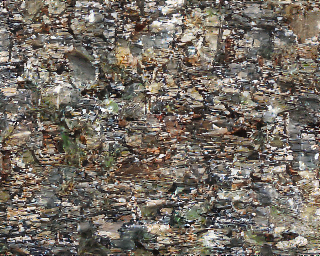

i: 25, loss: 1.89948


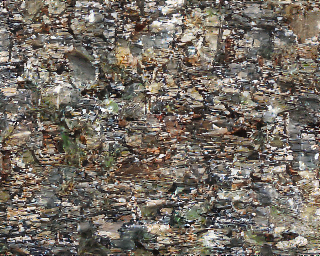

updated mse weight: 0.4
i: 50, loss: 2.55989


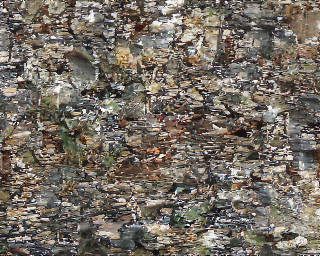

i: 75, loss: 1.14346


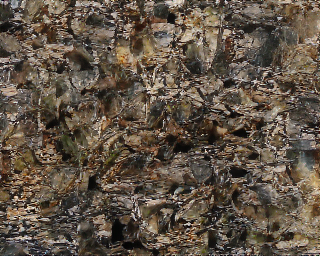

updated mse weight: 0.30000000000000004
i: 100, loss: 1.35813


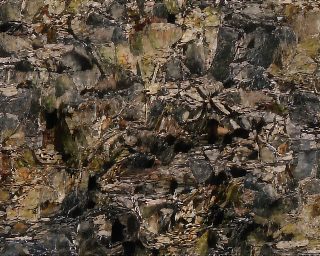

i: 125, loss: 0.935137


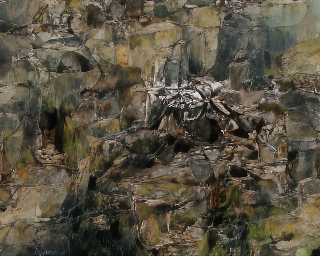

updated mse weight: 0.20000000000000004
i: 150, loss: 1.1107


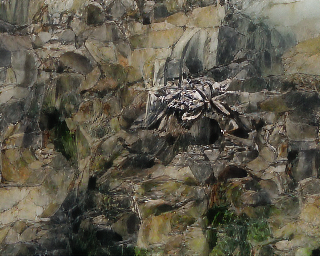

i: 175, loss: 0.823149


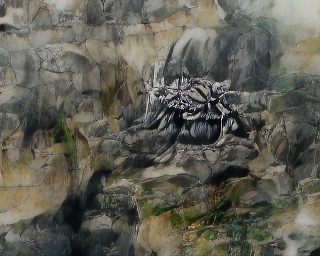

updated mse weight: 0.10000000000000003
i: 200, loss: 0.915882


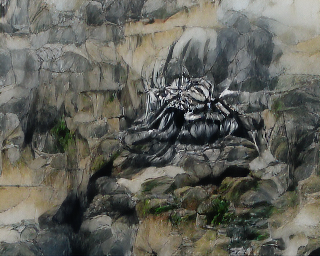

updated mse weight: 0
i: 300, loss: 0.647733


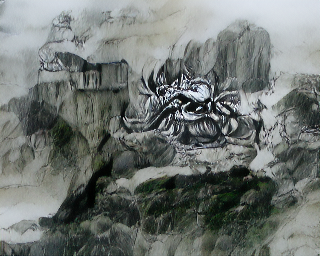

i: 400, loss: 0.596855


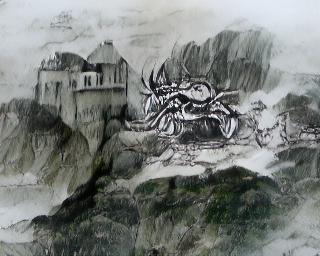

i: 500, loss: 0.582803


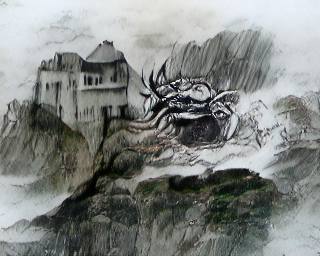

i: 600, loss: 0.571356


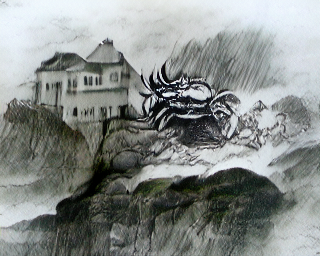

i: 700, loss: 0.57463


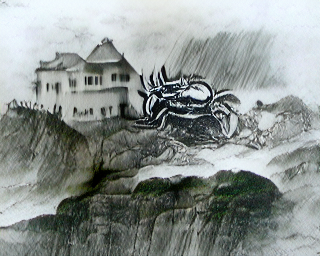

i: 800, loss: 0.569183


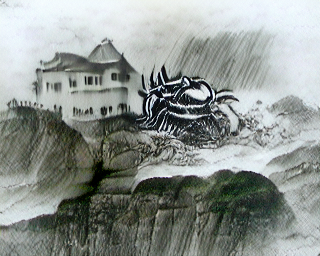

i: 900, loss: 0.570056


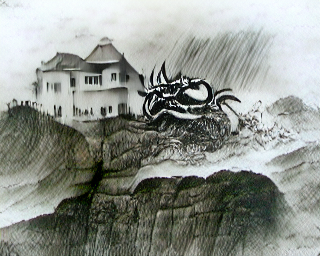

i: 1000, loss: 0.558254


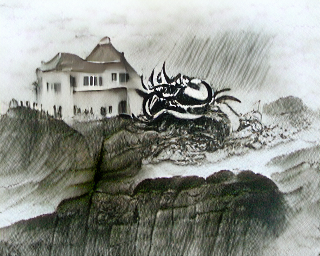

In [19]:
if args.mse_withzeros and not args.init_image:
  z_orig = torch.zeros_like(z.tensor)
else:
  z_orig = z.tensor.clone()


opt = optim.Adam(z.parameters(), lr=args.step_size, weight_decay=0.00000000)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

pMs = []

if args.noise_prompt_weights and args.noise_prompt_seeds:
  for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    gen = torch.Generator().manual_seed(seed)
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    pMs.append(Prompt(embed, weight).to(device))

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))
    # pMs[0].embed = pMs[0].embed + Prompt(embed, weight, stop).embed.to(device)


def synth(z, quantize=True):
    if args.constraint_regions:
      z = replace_grad(z, z * z_mask)

    if quantize:
      if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
      else:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)

    else:
      z_q = z.model

    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}')#', losses: {losses_str}')
    out = synth(z.average, True)

    TF.to_pil_image(out[0].cpu()).save('progress.png')   
    display.display(display.Image('progress.png')) 


def ascend_txt():
    global mse_weight

    out = synth(z.tensor)

    if args.record_generation:
      with torch.no_grad():
        global vid_index
        out_a = synth(z.average, True)
        TF.to_pil_image(out_a[0].cpu()).save(f'./content/vids/{vid_index}.png')
        vid_index += 1

    cutouts = make_cutouts(out)

    if args.use_augs:
      cutouts = augs(cutouts)

    if args.noise_fac:
      facs = cutouts.new_empty([args.cutn, 1, 1, 1]).uniform_(0, args.noise_fac)
      cutouts = cutouts + facs * torch.randn_like(cutouts)

    iii = perceptor.encode_image(normalize(cutouts)).float()

    result = []

    if args.init_weight:
        
        global z_orig
        
        result.append(F.mse_loss(z.tensor, z_orig) * mse_weight / 2)
        # result.append(F.mse_loss(z, z_orig) * ((1/torch.tensor((i)*2 + 1))*mse_weight) / 2)

        with torch.no_grad():
          if i > 0 and i%args.mse_decay_rate==0 and i <= args.mse_decay_rate*args.mse_epoches:

            if args.mse_quantize:
              z_orig = vector_quantize(z.average.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)#z.average
            else:
              z_orig = z.average.clone()

            if mse_weight - mse_decay > 0 and mse_weight - mse_decay >= mse_decay:
              mse_weight = mse_weight - mse_decay
              print(f"updated mse weight: {mse_weight}")
            else:
              mse_weight = 0
              print(f"updated mse weight: {mse_weight}")

    for prompt in pMs:
        result.append(prompt(iii))

    return result

vid_index = 0
def train(i):
    
    opt.zero_grad()
    lossAll = ascend_txt()

    if i < 200 and i % args.display_freq == 0:
        checkin(i, lossAll)
    if i >= 200 and i % 100 == 0:
        checkin(i, lossAll)
    
    loss = sum(lossAll)

    loss.backward()
    opt.step()
    z.update()

i = 0
try:
    with tqdm() as pbar:
        while True and i != args.max_itter:

            train(i)

            if i > 0 and i%args.mse_decay_rate==0 and i <= args.mse_decay_rate * args.mse_epoches:
              z = EMATensor(z.average, args.ema_val)
              opt = optim.Adam(z.parameters(), lr=args.step_size, weight_decay=0.00000000)

            i += 1
            pbar.update()

except KeyboardInterrupt:
    pass


# **Generate video**

In [20]:
#@markdown #*Double-click here and edit me*

# %cd ./content/vids

# images = "%d.png"
# video = "../content/old_man_iceberg.mp4"
# !ffmpeg -r 30 -i $images -crf 20 -s 640x512 -pix_fmt yuv420p $video

# %cd ..

/home/lobrien/anaconda3/envs/vqgan-clp/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Delete all frames from folder**

In [21]:
#@markdown Run this tab if you wanna clear all the genarated frames images


# %cd vids
# %rm *.png
# %cd ..

/home/lobrien/anaconda3/envs/vqgan-clp/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
